In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas
import experiments.fitting as fitter

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.DONOTUSE_ramsey_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
imported experiments.two_qubit.pulse_probe_EgGf_spectroscopy
imported experiments.two_qubit.randbench
i

Set save data

In [3]:
save_data = False

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [5]:
# expt_path=os.getcwd()+'\data\data_220623'
# expt_path=os.getcwd()+'\data\data_220712'
# expt_path=os.getcwd()+'\data\data_220801'
# expt_path=os.getcwd()+'\data\data_220904'
# expt_path=os.getcwd()+'\data\data_220919'
# expt_path=os.getcwd()+'\data\data_220929'
# expt_path=os.getcwd()+'\data\data_221007'
# expt_path=os.getcwd()+'\data\data_221020'
expt_path=os.getcwd()+'\data\data_221215'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_221215


In [6]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


Load config

In [7]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Qubit/resonator to probe

In [8]:
all_results = [dict(), dict(), dict(), dict()]
saved_files = []

In [10]:
qubit_i = 1
results_Qi = all_results[qubit_i]

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [11]:
im = InstrumentManager(ns_address='192.168.14.1')

In [17]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print(f'set freq to [MHz] {lo_freq*1e-6}')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to [MHz] 5925.0
set power to 7.0


In [12]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

soc = QickConfig(im['Qick187'].get_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, envelope mem

In [40]:
# print(list(im))
# print(im)

# RFSoC Calibration

In [20]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=1.0, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=500, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
# print(tof.cfg)

import Pyro4.util
try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

215 307
readout freq 950 +/- -812.617


  0%|          | 0/500 [00:00<?, ?it/s]

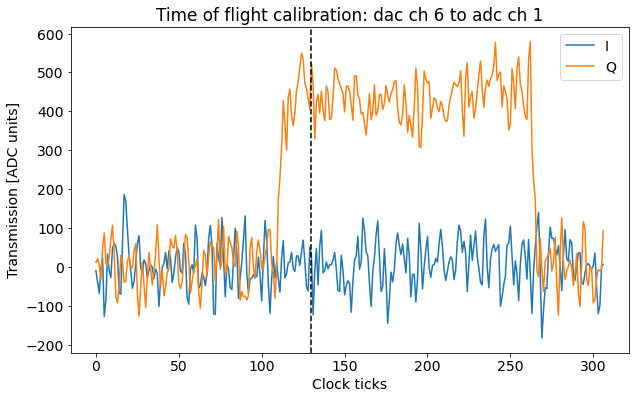

In [21]:
tof.display(adc_trig_offset=130)

# Initial single tone resonator spectroscopy

In [22]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
rspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 1.0 # MHz
npts = 150
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec.cfg.device.readout.gain = 0.850
rspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]

import Pyro4.util
try:
    rspec.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/150 [00:00<?, ?it/s]

[-812.6203333333332, 5000, 1000, 0, 202.2727628781568, 192.61559501314122, -63.68022482948942]

Freq with minimum transmission: -812.9236666666666
Freq with maximum transmission: -812.2969999999999
From fit:
	f0: -812.6203333333332
	Qi: 5000
	Qe: 1000
	Q0: 833.3333333333333
	kappa [MHz]: -0.9751443999999999
	phi [radians]: 0


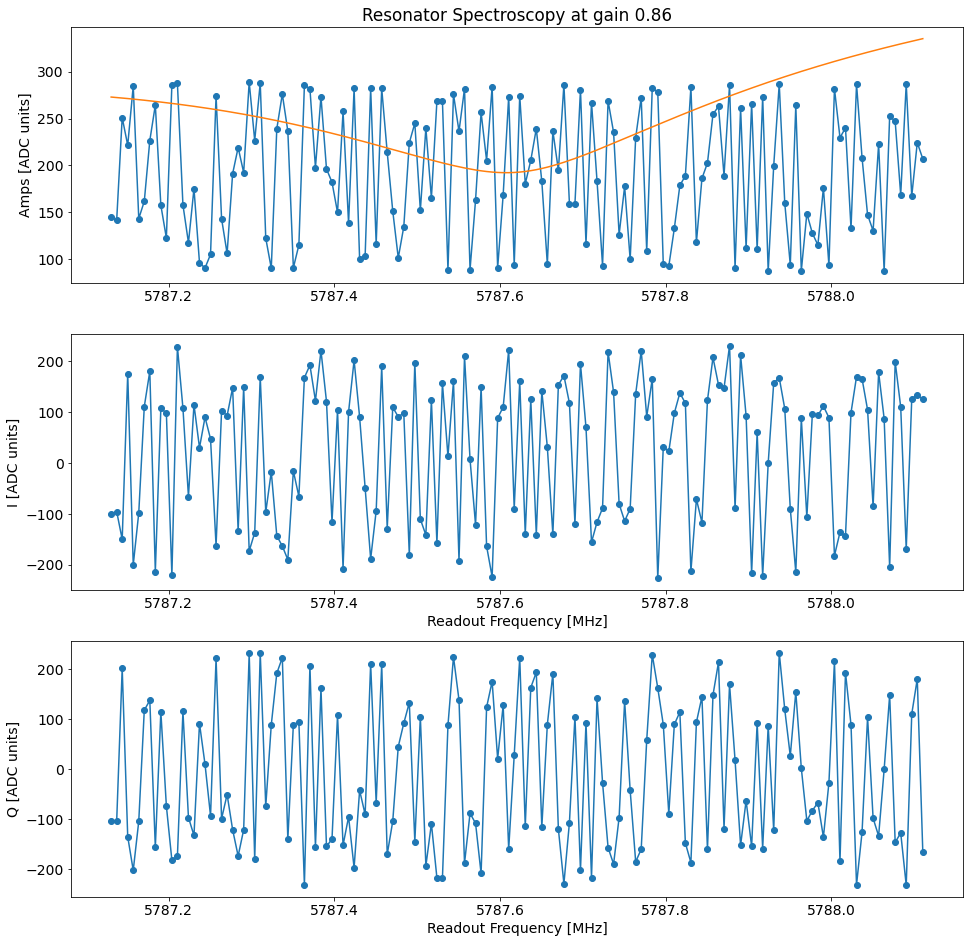

*Set cfg res 1 freq to -812.9236666666666*
*Set cfg res 1 gain to 0.86*
[{}, {'Res freq': 5787.923666666667, 'Res kappa': 0.9751443999999999}, {}, {}]


In [23]:
 # TESTING
# # rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec.data = temp_data

rspec.analyze(fit=True)
rspec_fit = rspec.data['fit']
# if not isinstance(rspec_fit, (list, np.ndarray)):
#     rspec.display(fit=False)
#     assert False, 'Fit failed, please manually fix!'
rspec.display(fit=True)
# yaml_cfg.device.readout.frequency[qubit_i] = rspec_fit[0]
yaml_cfg.device.readout.frequency[qubit_i] = rspec.data['xpts'][np.argmin(rspec.data['amps'])]
yaml_cfg.device.readout.gain[qubit_i] = rspec.cfg.device.readout.gain
print(f'*Set cfg res {qubit_i} freq to {yaml_cfg.device.readout.frequency[qubit_i]}*')
print(f'*Set cfg res {qubit_i} gain to {yaml_cfg.device.readout.gain[qubit_i]}*')
results_Qi.update({'Res freq':float(yaml_cfg.hw.lo.readout.frequency)*1e-6 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.device.readout.frequency[qubit_i] + yaml_cfg.hw.soc.dacs.readout.mixer_freq)})
results_Qi.update({'Res kappa':abs(rspec_fit[0]*(1/rspec_fit[1] + 1/rspec_fit[2]))})
print(all_results)

In [64]:
if save_data: saved_files.append(rspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00002_resonator_spectroscopy_qubit0.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

In [102]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 200
npts = 200

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=10, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/10), # Qubit pulse gain
    qubit=qubit_i,
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 425.39897869484673, HWHM -4.068348731241603
Found peak in I at [MHz] 461.6261043075996, HWHM 115.98710098283237
Found peak in Q at [MHz] 425.12424769246013, HWHM -5.047456008381674


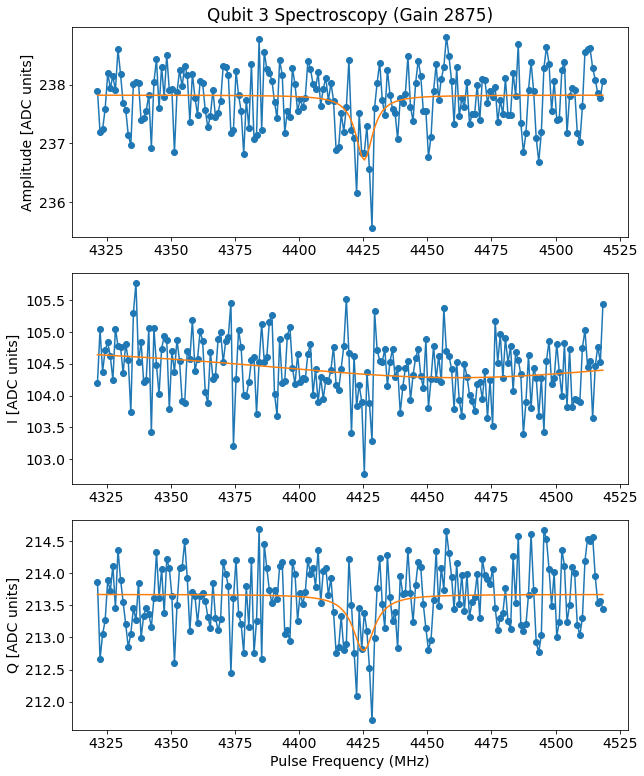

*Set qubit 3 f_ge to 425.39897869484673*
[{'Qubit freq': 4145.6696618844235, 'Pi pulse len': 0.21621550537601955, 'Pi pulse gain': 4133, 'T1': 26.580748110408035, 'T1 err': 5.081093510765457}, {}, {'Res freq': 7693.839333333333, 'Res kappa': 0.18297517457435744, 'Qubit freq': 4808.08917302461, 'Pi pulse len': 0.05851958540275149, 'Pi pulse gain': 18050, 'T1': 9.261929702812196, 'T1 err': 0.5272496289468025}, {'Qubit freq': 4425.398978694847}]


In [103]:
# # TESTING
# # qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qspec.data['fit_err_avgi'][2][2]
        fit_err_q = qspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec.analyze(fit=True, signs=best_signs)
qspec.display(fit=True, signs=best_signs)

qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec_fit[2]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [40]:
if save_data: saved_files.append(qspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00003_qubit_spectroscopy_qubit0.h5


## Pulse Probe (qubit) spectroscopy round 2

In [104]:
qspec2 = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 150

qspec2.cfg.expt = dict(
    start=qspec2.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=10, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/10), # Qubit pulse gain
    qubit=qubit_i,
)
qspec2.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 446.9649326022772, HWHM 1.375534625525409
Found peak in I at [MHz] 430.87807618038846, HWHM 34.83621979763246
Found peak in Q at [MHz] 446.5494138440594, HWHM 1.9713772269149417


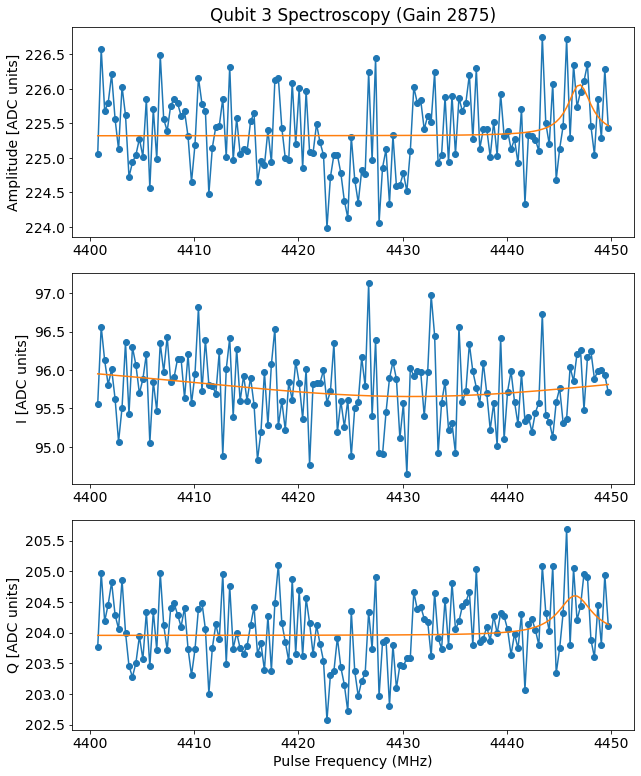

*Set qubit 3 f_ge to 446.9649326022772*
[{'Qubit freq': 4145.6696618844235, 'Pi pulse len': 0.21621550537601955, 'Pi pulse gain': 4133, 'T1': 26.580748110408035, 'T1 err': 5.081093510765457}, {}, {'Res freq': 7693.839333333333, 'Res kappa': 0.18297517457435744, 'Qubit freq': 4808.08917302461, 'Pi pulse len': 0.05851958540275149, 'Pi pulse gain': 18050, 'T1': 9.261929702812196, 'T1 err': 0.5272496289468025}, {'Qubit freq': 4446.964932602277}]


In [105]:
# # TESTING
# # qspec2 = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec2.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec2.analyze(fit=True, signs=[1, sign, sign])
        fit_err_amps = qspec2.data['fit_err_amps'][2][2]
        fit_err_i = qspec2.data['fit_err_avgi'][2][2]
        fit_err_q = qspec2.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec2.analyze(fit=True, signs=best_signs)
qspec2.display(fit=True, signs=best_signs)

qspec2_fit, qspec2_fit_err = meas.fitting.get_best_fit(qspec2.data)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec2_fit[2]
qubit_hwhm = qspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [43]:
if save_data: saved_files.append(qspec2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00004_qubit_spectroscopy_qubit0.h5


## Length Rabi

In [66]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabi.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabi.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=121,
    reps=3000,
    gain=20000, # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)
lengthrabi.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabi.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/121 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 52.499475000000004, which is out of bounds 0.294114705882353 to 44.11720588235294. Instead init to 22.205660294117646
Decay from avgi [us] 0.1020010200102001
Pi length from avgi data [us]: 0.008100313101543142
	Pi/2 length from avgi data [us]: 0.004050156550771571

Decay from avgq [us] 0.1887145459230443
Pi length from avgq data [us]: 0.06502176155861276
Pi/2 length from avgq data [us]: 0.03251088077930638


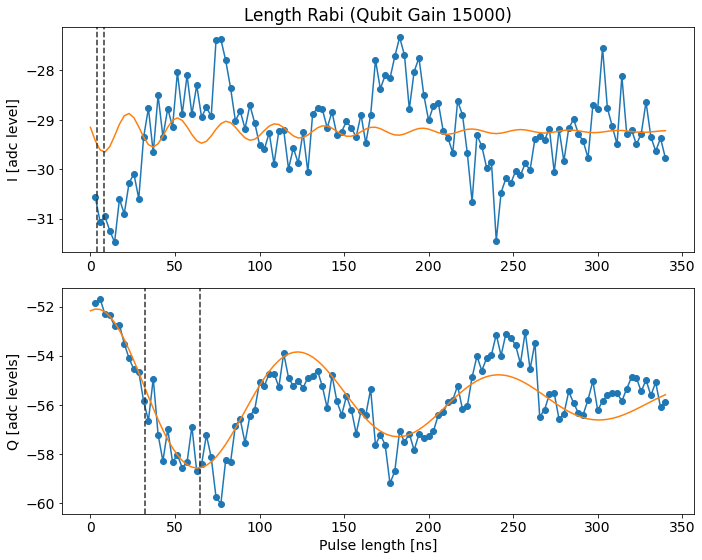

Will use sigma 0.05851958540275149 for amplitude rabi


In [67]:
# # TESTING
# # lengthrabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabi.data = temp_data

lengthrabi.analyze(fit=True)

lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabi.data) #, fitfunc=fitter.decaysin)

lengthrabi.display(fit=True)
p = lengthrabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
else: pi_len = (3/2 - p[2]/180)/2/p[1]
pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain

lengthrabi_decay = p[3]

print(f'Will use sigma {pi_len} for amplitude rabi')

In [53]:
if save_data: saved_files.append(lengthrabi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00004_length_rabi_qubit0.h5


## Amplitude Rabi

In [68]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 32000
npts = 151
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    # reps=5,
    rounds=30,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=False, 
    qubits=[qubit_i],
)
amprabi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.001674565560821485, which is out of bounds 3.1807627469067084e-06 to 0.0004771144120360062. Instead init to 0.00024014758739145645
Pi gain from avgi data [dac units]: 5233
	Pi/2 gain from avgi data [dac units]: 2616
Pi gain from avgq data [dac units]: 18050
	Pi/2 gain from avgq data [dac units]: 9025


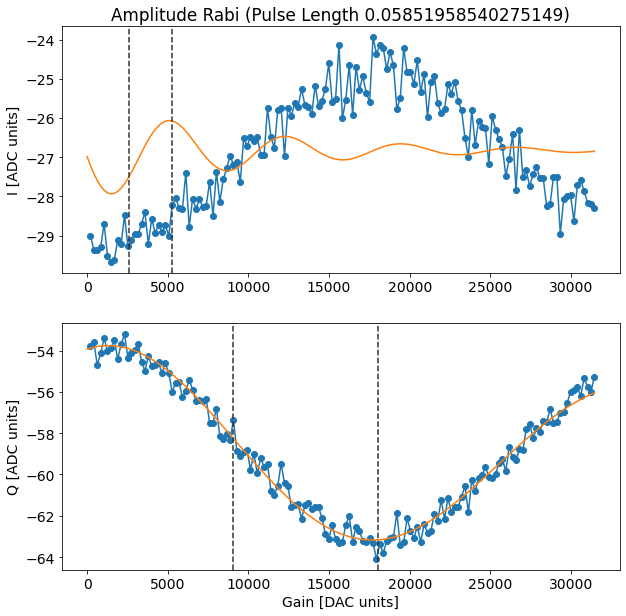

*Set pi pulse sigma for qubit 2 to 0.05851958540275149*
*Set pi pulse gain for qubit 2 to 18050*
[{'Qubit freq': 4145.6696618844235, 'Pi pulse len': 0.21621550537601955, 'Pi pulse gain': 4133, 'T1': 26.580748110408035, 'T1 err': 5.081093510765457}, {}, {'Res freq': 7693.839333333333, 'Res kappa': 0.18297517457435744, 'Qubit freq': 4808.08917302461, 'Pi pulse len': 0.05851958540275149, 'Pi pulse gain': 18050}, {'Qubit freq': 4423.362631795915}]


In [69]:
# # TESTING
# # amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi.data = temp_data

amprabi.analyze(fit=True)

amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

p = amprabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabi.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi.cfg.expt.sigma_test

print(f'*Set pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]}*')
results_Qi.update({'Pi pulse len':yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]})
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]})
print(all_results)

In [25]:
if save_data: saved_files.append(amprabi.save_data())

## $T_1$

In [70]:
# if lengthrabi_decay < 10: short_T1 = True
# else: short_T1 = False
short_T1 = True

In [71]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)
t1.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50 if short_T1 else 300
npts = 151

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=100,
    # reps=5,
    rounds=30,
    qubit=qubit_i,
)
t1.cfg.device.readout.relax_delay = span # Wait time between experiments [us]
t1.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Fit T1 avgi [us]: 13.316414859975085
Fit T1 avgq [us]: 10.560207718189531


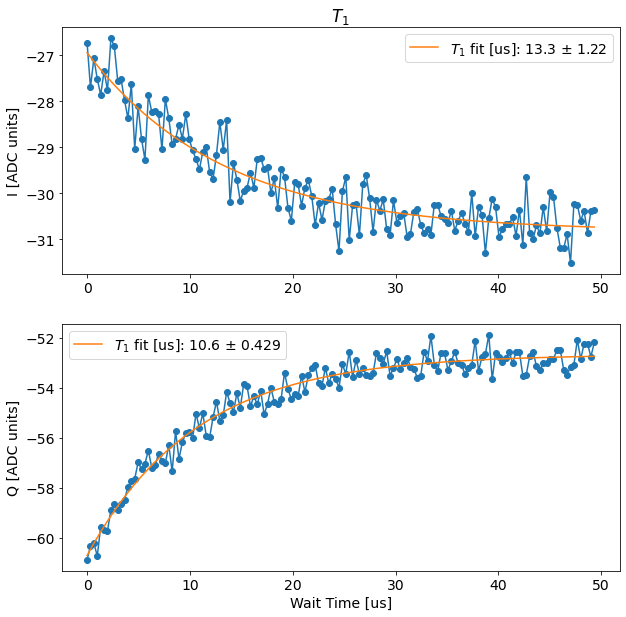

*Set qubit 2 T1 to 9.0*
*Set readout 2 relax delay to 28.0*
[{'Qubit freq': 4145.6696618844235, 'Pi pulse len': 0.21621550537601955, 'Pi pulse gain': 4133, 'T1': 26.580748110408035, 'T1 err': 5.081093510765457}, {}, {'Res freq': 7693.839333333333, 'Res kappa': 0.18297517457435744, 'Qubit freq': 4808.08917302461, 'Pi pulse len': 0.05851958540275149, 'Pi pulse gain': 18050, 'T1': 9.261929702812196, 'T1 err': 0.5272496289468025}, {'Qubit freq': 4423.362631795915}]


In [72]:
# # TESTING
# # t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# t1.data = temp_data

t1.analyze(fit=True)

t1_fit, t1_fit_err = meas.fitting.get_best_fit(t1.data) #, fitter.expfunc)

t1.display(fit=True)
yaml_cfg.device.qubit.T1[qubit_i] = np.round(t1_fit[3])
yaml_cfg.device.readout.relax_delay[qubit_i] = np.round(3*t1_fit[3])
print(f'*Set qubit {qubit_i} T1 to {yaml_cfg.device.qubit.T1[qubit_i]}*')
print(f'*Set readout {qubit_i} relax delay to {yaml_cfg.device.readout.relax_delay[qubit_i]}*')
results_Qi.update({'T1':t1_fit[3], 'T1 err':np.sqrt(t1_fit_err[3][3])})
print(all_results)

In [213]:
if save_data: saved_files.append(t1.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00000_t1_qubit3.h5


## $T_2$ Ramsey round 1

In [73]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
# qubit_hwhm = 2
# short_T1 = False
short_T1 = yaml_cfg.device.qubit.T1[qubit_i] < 20

In [78]:
ramsey_freq = max(min(np.abs(np.ceil(qubit_hwhm)), 3), 2)
ramsey_freq = 1
print(f'Ramsey freq [MHz]: {ramsey_freq}')

t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(1) if short_T1 else soc.cycles2us(15), # [us] 
    # step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us] 
    expts=151,
    ramsey_freq=ramsey_freq, # [MHz]
    reps=100,
    # reps=5,
    rounds=40,
    qubits=[qubit_i],
    checkZZ=False,
    checkEF=False,
)

import Pyro4.util
try:
    t2r.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

Ramsey freq [MHz]: 1


  0%|          | 0/40 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 174.99825, which is out of bounds 0.23489697986577185 to 35.234546979865776. Instead init to 17.734721979865775
Attempted to init fitparam 1 to 37.33296, which is out of bounds 0.23489697986577185 to 35.234546979865776. Instead init to 17.734721979865775
Current pi pulse frequency: 808.697308500101
Fit frequency from I [MHz]: 18.342693934161417 +/- 1.348078108560638
Suggested new pi pulse frequency from fit I [MHz]:
 	791.3546145659396
 	789.3546145659396
T2 Ramsey from fit I [us]: 0.1277155628703915
Fit frequency from Q [MHz]: 9.443361642522722 +/- 0.401482298764372
Suggested new pi pulse frequencies from fit Q [MHz]:
 	800.2539468575783
 	798.2539468575783
T2 Ramsey from fit Q [us]: 0.280148706220656


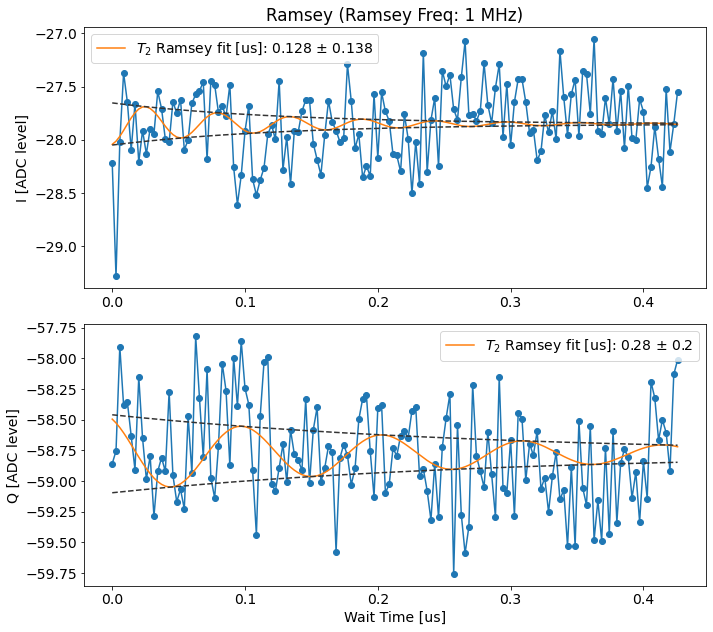

*Set qubit 2 freq to 793.0787912709092*
Alt qubit freq is 791.0787912709092


In [79]:
# # TESTING
# # t2r = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r.data = temp_data

t2r.analyze(fit=True)

t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])

old_qubit_freq = t2r.cfg.device.qubit.f_ge[qubit_i]
t2r.display(fit=True)
yaml_cfg.device.qubit.f_ge[qubit_i] = old_qubit_freq + t2r_adjust[0]
alt_qubit_freq = old_qubit_freq + t2r_adjust[1]
print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Alt qubit freq is {alt_qubit_freq}')

In [ ]:
if save_data: saved_files.append(t2r.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00000_ramsey_qubit0.h5


## $T_2$ Ramsey round 2

Check that frequency adjustment helps.

In [ ]:
t2r_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r_2.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(2) if short_T1 else soc.cycles2us(60), # [us]
    expts=151,
    ramsey_freq=ramsey_freq/10, # [MHz]
    reps=100,
    # reps=10,
    rounds=30,
    checkZZ=False,
    checkEF=False,
    qubits=[qubit_i],
)
t2r_2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 1.166655, which is out of bounds 0.0039149496644295305 to 0.5872424496644295. Instead init to 0.2955786996644295
Current pi pulse frequency: 805.5753498070502
Fit frequency from I [MHz]: 0.1222643786768293 +/- 0.007899828407901899
Suggested new pi pulse frequency from fit I [MHz]:
 	805.6530854283734
 	805.2530854283734
T2 Ramsey from fit I [us]: 15.470678873546804
Fit frequency from Q [MHz]: 0.23896786490974967 +/- 0.025385190124992567
Suggested new pi pulse frequencies from fit Q [MHz]:
 	805.5363819421405
 	805.1363819421405
T2 Ramsey from fit Q [us]: 10.270866099213615


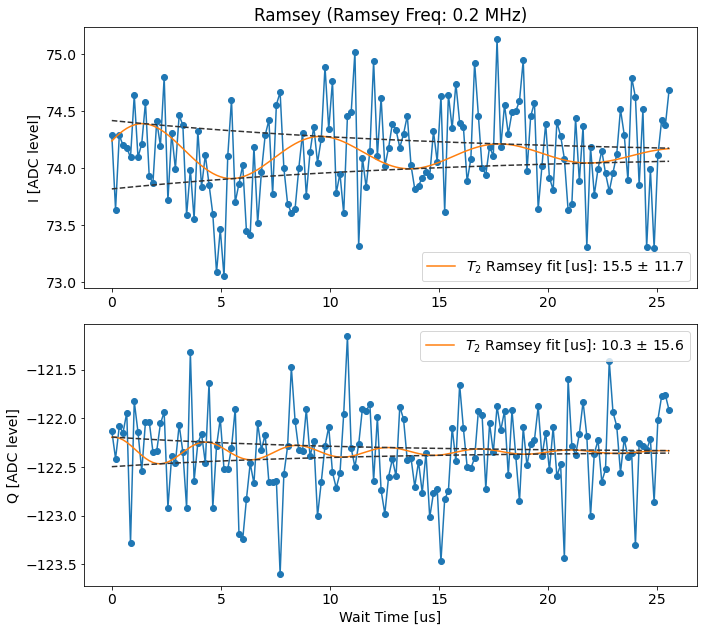

*Set qubit 2 freq to 805.5363819421405*
[{'Pi pulse len': 0.03538834796958753, 'Pi pulse gain': 30306, 'T1': 23.837184072247744, 'T1 err': 1.7375313859817623, 'T2E': 14.614055894561945, 'T2E err': 0.730402411422165, 'Qubit EF freq': 4617.045765466059, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 13626}, {}, {'Res freq': 6801.3, 'Res kappa': 0.1257754755658977, 'Qubit freq': 4805.53638194214, 'Pi pulse len': 0.04030935960177951, 'Pi pulse gain': 24653, 'T1': 29.281820009664354, 'T1 err': 5.806717304354948, 'T2R': 10.270866099213615, 'T2R err': 15.610875778306665}, {}]
Redo T2R: False


In [ ]:
# # TESTING
# # t2r_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r_2.data = temp_data

redo_t2r = True

t2r_2.analyze(fit=True)

t2r_2_fit, t2r_2_fit_err, t2r_2_adjust = meas.fitting.get_best_fit(t2r_2.data, get_best_data_params=['f_adjust_ramsey'])

t2r_2.display(fit=True)
final_qubit_freq = t2r_2.cfg.device.qubit.f_ge[qubit_i] + t2r_2_adjust[0]
if abs(t2r_2_adjust[0]) <= abs(t2r_adjust[0]):
    redo_t2r = False
    yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
    results_Qi.update({'T2R':t2r_2_fit[3], 'T2R err':np.sqrt(t2r_2_fit_err[3][3])})
    results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(all_results)
else: # redo_t2r = True
    yaml_cfg.device.qubit.f_ge[qubit_i] = alt_qubit_freq 
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Redo T2R: {redo_t2r}')

In [ ]:
if save_data: saved_files.append(t2r_2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00001_ramsey_qubit2.h5


## $T_2$ Ramsey round 3

Run again in case adjust frequency in the wrong direction previously.

In [ ]:
if redo_t2r:
    t2r_3 = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{qubit_i}",
        config_file=config_path,
    )
    t2r_3.cfg = AttrDict(deepcopy(yaml_cfg))

    # make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    t2r_3.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us]
        expts=151,
        ramsey_freq=ramsey_freq/2, # [MHz]
        reps=100,
        # reps=10,
        rounds=30,
        checkZZ=False,
        checkEF=False,
        qubit=[qubit_i],
    )
    t2r_3.go(analyze=False, display=False, progress=True, save=False)

In [ ]:
if redo_t2r:
    # # TESTING
    # # t2r_3 = meas.RamseyExperiment(config_file=config_path)
    # temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
    # t2r_3.data = temp_data

    t2r_3.analyze(fit=True)

    t2r_3_fit, t2r_3_fit_err, t2r_3_adjust = meas.fitting.get_best_fit(t2r_3.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

    if not isinstance(t2r_3_fit, (list, np.ndarray)):
        t2r_3.display(fit=True)
        final_qubit_freq = t2r_3.cfg.device.qubit.f_ge + t2r_3_adjust[0]
        if abs(t2r_3_adjust[0]) <= abs(t2r_adjust[0]):
            yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
            print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
            i_best = np.argmin([t2r_fit_err[3][3], t2r_3_fit_err[3][3]])
            results_Qi.update({'T2':[t2r_fit[3], t2r_3_fit[3]][i_best], 'T2 err':np.sqrt([t2r_fit_err[3][3], t2r_3_fit_err[3][3]][i_best])})
            results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
            print(all_results)
        else:
            assert False, 'Something is wrong, please manually fix!'
    else:
        t2r_3.display(fit=False)
        assert False, 'Fit failed, please manually fix!'

In [ ]:
if redo_t2r:
    if save_data: saved_files.append(t2r_3.save_data())

## $T_2$ Echo

In [227]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)
t2e.cfg = AttrDict(deepcopy(yaml_cfg))

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(60), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=151,
    ramsey_freq=max(ramsey_freq/10, 0.100), # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=100,
    # reps=10,
    rounds=30,
    qubit=qubit_i,
)
t2e.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.7388815, which is out of bounds 0.0039149496644295305 to 0.5872424496644295. Instead init to 0.2955786996644295
Current qubit frequency: 425.57
Fit frequency from I [MHz]: 0.19820007398259304 +/- 0.0021187452565828804
T2 Echo from fit I [us]: 15.142344187443841
Fit frequency from Q [MHz]: 0.19979727002278858 +/- 0.0028997692553862564
T2 Echo from fit Q [us]: 17.09850035580177


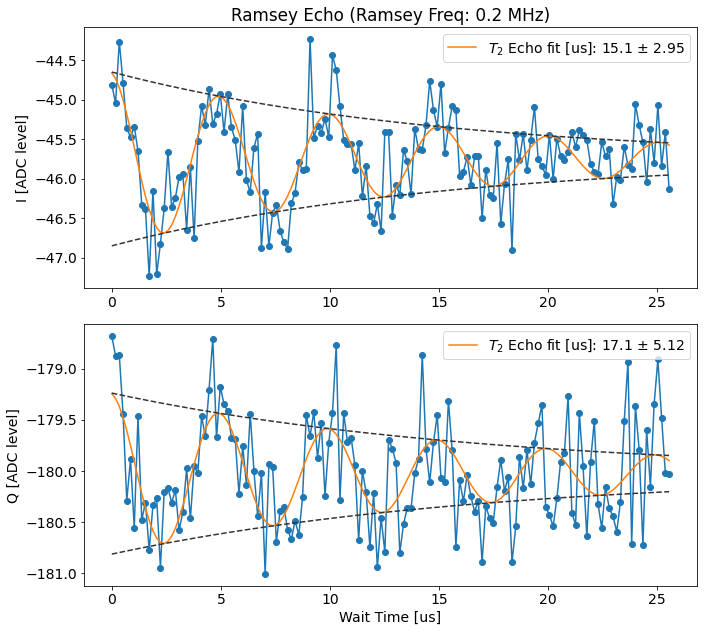

[{'Pi pulse len': 0.03538834796958753, 'Pi pulse gain': 30306, 'T1': 23.837184072247744, 'T1 err': 1.7375313859817623, 'T2E': 14.614055894561945, 'T2E err': 0.730402411422165, 'Qubit EF freq': 4617.045765466059, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 13626, 'Res kappa': 0.183}, {'Res kappa': 0.22}, {'Res freq': 6801.3, 'Res kappa': 0.125, 'Qubit freq': 4805.53638194214, 'Pi pulse len': 0.04030935960177951, 'Pi pulse gain': 24653, 'T1': 29.281820009664354, 'T1 err': 5.806717304354948, 'T2R': 10.270866099213615, 'T2R err': 15.610875778306665, 'T2E': 8.64803302418429, 'T2E err': 0.7408613553193386, 'Qubit EF freq': 3921.0962368402807, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 31065}, {'Res freq': 6962.08, 'Res kappa': 0.06175233106643036, 'Qubit freq': 4425.747832301907, 'Pi pulse len': 0.029722756144104433, 'Pi pulse gain': 22049, 'T1': 34.971737439167, 'T1 err': 11.792087939662995, 'T2E': 17.09850035580177, 'T2E err': 5.117791181336998}]


In [228]:
# # TESTING
# # t2e = meas.RamseyEchoExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# t2e.data = temp_data

t2e.analyze(fit=True)

t2e_fit, t2e_fit_err = meas.fitting.get_best_fit(t2e.data)

if not isinstance(t2e_fit, (list, np.ndarray)):
    t2e.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

t2e.display(fit=True)
results_Qi.update({'T2E':t2e_fit[3], 'T2E err':np.sqrt(t2e_fit_err[3][3])})
print(all_results)
# print('Results updated.')

In [229]:
if save_data: saved_files.append(t2e.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00000_echo_qubit3.h5


# Resonator chi shift (g/e)

In [120]:
rspec_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspec_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 151
rspec_chi.cfg.expt = dict(
    start=rspec_chi.cfg.device.readout.frequency[qubit_i]-span/2, # MHz
    # start=rspec_chi.cfg.device.readout.frequency[qubit_i]-rspec_chi.cfg.device.readout.lo_sideband[qubit_i]*span, # MHz
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspec_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

[-808.3161720994943, 5000, 1000, 0, 31.972478802377907, 338.4097714428876]

Freq with minimum transmission: -807.7532581922094
Freq with maximum transmission: -805.9320661392293
From fit:
	f0: -808.3161720994943
	Qi: 5000
	Qe: 1000
	Q0: 833.3333333333333
	kappa [MHz]: -0.9699794065193933
	phi [radians]: 0


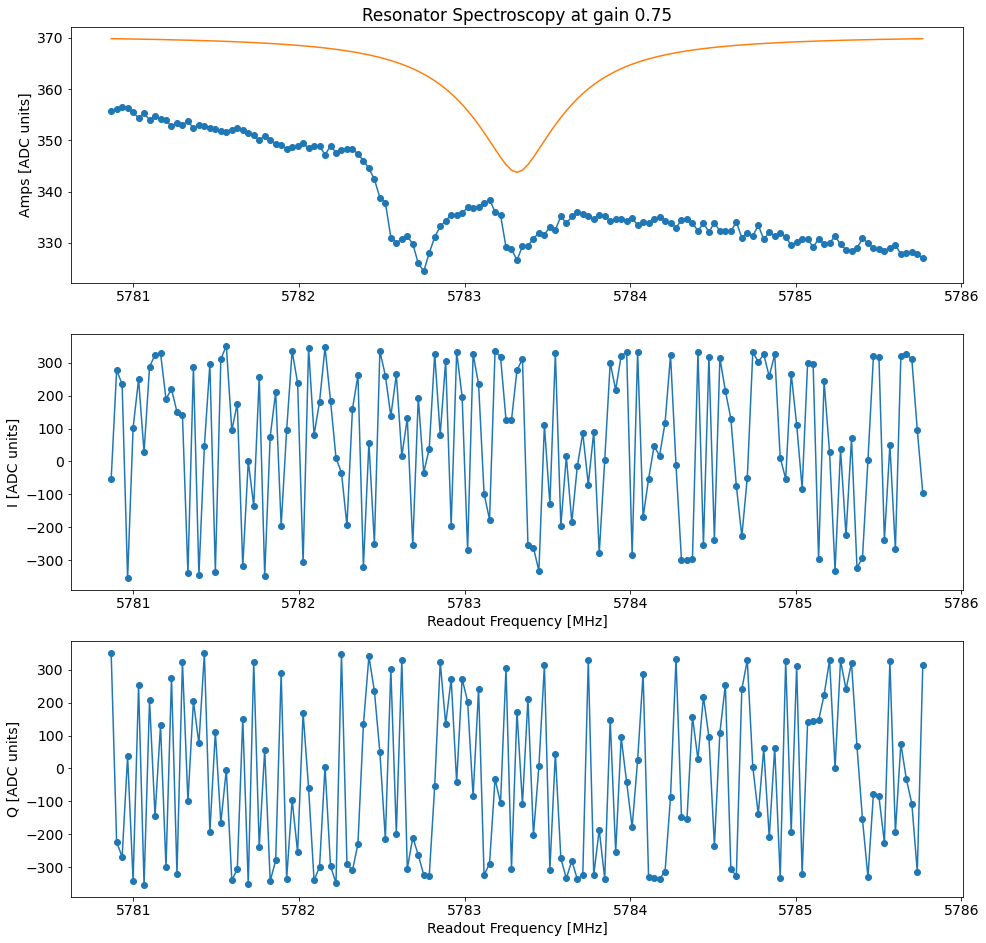

[{'Res freq': 7688.874258045896, 'Res kappa': 0.9756441096550745, 'Qubit freq': 4823.861508259508, 'Pi pulse len': 0.03956011335259716, 'Pi pulse gain': 22779, 'T1': 97.14424019836063, 'T1 err': 4.6355555889821245, 'T2R': 8.312336278065233, 'T2R err': 0.3957274632565941, 'T2E': 17.688832442781287, 'T2E err': 0.7326171278801736, 'Qubit EF freq': 4640.557961214359, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 16093}, {'Res freq': 5783.299615808103, 'Res kappa': 0.30608491399697296, 'Qubit freq': 3472.403818423059, 'Pi pulse len': 0.020738980081829388, 'Pi pulse gain': 23185, 'T1': 52.567929832315315, 'T1 err': 0.6768379550408044, 'T2R': 1.8746149564710788, 'T2R err': 0.1533478261277939, 'T2E': 15.873701812556538, 'T2E err': 0.3698073838910515, 'Res chi shift (e - g)': -0.5463576158940668, 'Qubit EF freq': 603.7170605500958, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 2680, 'Res chi shift (f - g)': 5.546357615894067}, {}, {}]


In [121]:
# # TESTING
# # rspec_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec_chi.data = temp_data

rspec_chi.analyze(fit=True)
rspec_chi_fit = rspec_chi.data['fit']
if not isinstance(rspec_chi_fit, (list, np.ndarray)):
    rspec_chi.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
rspec_chi.display(fit=True)
# res_freq_e = rspec_chi_fit[0]
res_freq_e = rspec_chi.data['xpts'][np.argmin(rspec_chi.data['amps'])]
# res_freq_e = -83
results_Qi.update({'Res chi shift (e - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_e = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [ ]:
if save_data: saved_files.append(rspec_chi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220919\00000_resonator_spectroscopy_chi_qubit3.h5


# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

In [57]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 100
npts = 180

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=2, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/10), # ef pulse gain
    # gain=5000,
    qubit=qubit_i,
)
qEFspec.cfg.device.readout.relax_delay = qEFspec.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Found peak in amps at [MHz] 643.7124321327256, HWHM 9.833333333333337
Found peak in I at [MHz] 612.5214299803872, HWHM 3.3661922970824407
Found peak in Q at [MHz] 612.5297176800001, HWHM 2.161509368553695


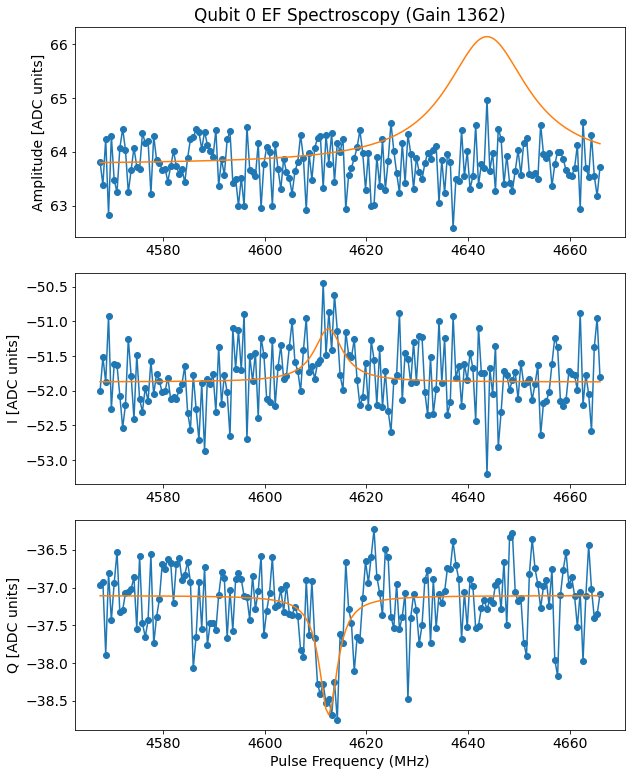

*Set qubit 0 f_ef to 612.5297176800001*
[{'Qubit freq': 4810.826541944993, 'Pi pulse len': 0.0663891935742529, 'Pi pulse gain': 16026, 'Qubit EF freq': 4612.52971768}, {'EF pi pulse len': 0.025, 'EF pi pulse gain': 13371, 'Qubit freq': 3423.5931244406192, 'Res freq': 5787.403666666667, 'Res kappa': 0.9751443999999999, 'Qubit EF freq': 3364.2533372060493}, {}, {}]


In [58]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qEFspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qEFspec.data['fit_err_avgi'][2][2]
        fit_err_q = qEFspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec.analyze(fit=True, signs=best_signs)
qEFspec.display(fit=True, signs=best_signs)

better_fit = (qEFspec.data['fit_avgi'], qEFspec.data['fit_avgq'])[np.argmin((qEFspec.data['fit_err_avgi'][2][2], qEFspec.data['fit_err_avgq'][2][2]))]
yaml_cfg.device.qubit.f_ef[qubit_i] = better_fit[2]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [59]:
if save_data: saved_files.append(qEFspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00002_qubit_EF_spectroscopy_qubit0.h5


## Pulse Probe EF spectroscopy round 2

In [60]:
qEFspec2 = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 20
npts = 150

qEFspec2.cfg.expt = dict(
    start=qEFspec2.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=4, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/10), # ef pulse gain
    qubit=qubit_i,
)
qEFspec2.cfg.device.readout.relax_delay = qEFspec2.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Found peak in amps at [MHz] 603.6597524803901, HWHM 0.24297860631674817
Found peak in I at [MHz] 610.6243949870885, HWHM 3.4225678812795355
Found peak in Q at [MHz] 611.0983268858191, HWHM 2.9998654710560895


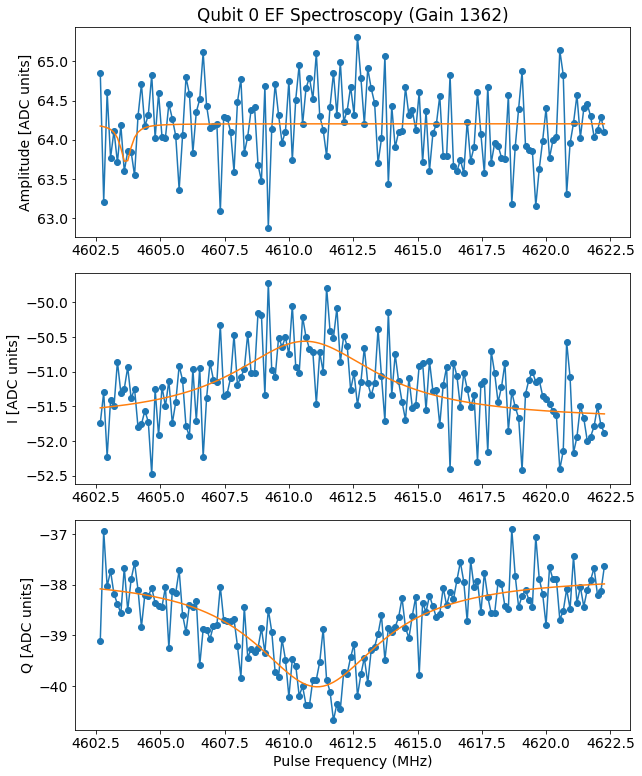

*Set qubit 0 f_ef to 611.0983268858191*
[{'Qubit freq': 4810.826541944993, 'Pi pulse len': 0.0663891935742529, 'Pi pulse gain': 16026, 'Qubit EF freq': 4611.098326885819}, {'EF pi pulse len': 0.025, 'EF pi pulse gain': 13371, 'Qubit freq': 3423.5931244406192, 'Res freq': 5787.403666666667, 'Res kappa': 0.9751443999999999, 'Qubit EF freq': 3364.2533372060493}, {}, {}]


In [61]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec2.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    qEFspec2.analyze(fit=True, signs=[1, sign, sign])
    fit_err_i = qEFspec2.data['fit_err_avgi'][2][2]
    fit_err_q = qEFspec2.data['fit_err_avgq'][2][2]
    if fit_err_i < best_fit_err_i:
        best_signs[1] = sign
        best_fit_err_i = fit_err_i
    if fit_err_q < best_fit_err_q:
        best_signs[2] = sign
        best_fit_err_q = fit_err_q
    # except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec2.analyze(fit=True, signs=best_signs)
qEFspec2.display(fit=True, signs=best_signs)

qEFspec2_fit, qEFspec2_fit_err = meas.fitting.get_best_fit(qEFspec2.data)

yaml_cfg.device.qubit.f_ef[qubit_i] = qEFspec2_fit[2]
qubitEF_hwhm = qEFspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [62]:
if save_data: saved_files.append(qEFspec2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00003_qubit_EF_spectroscopy_qubit0.h5


## Length EF Rabi

In [109]:
lengthrabiEF = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabiEF_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabiEF.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=121,
    reps=3000,
    gain=20000, # qubit gain [DAC units],
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)
# lengthrabiEF.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]

import Pyro4.util
try:
    lengthrabiEF.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/121 [00:00<?, ?it/s]

Decay from avgi [us] 0.4007577563595996
Pi length from avgi data [us]: 0.018441998126602605
	Pi/2 length from avgi data [us]: 0.009220999063301302

Decay from avgq [us] 0.32643876997479854
Pi length from avgq data [us]: 0.05011925786125089
Pi/2 length from avgq data [us]: 0.025059628930625445


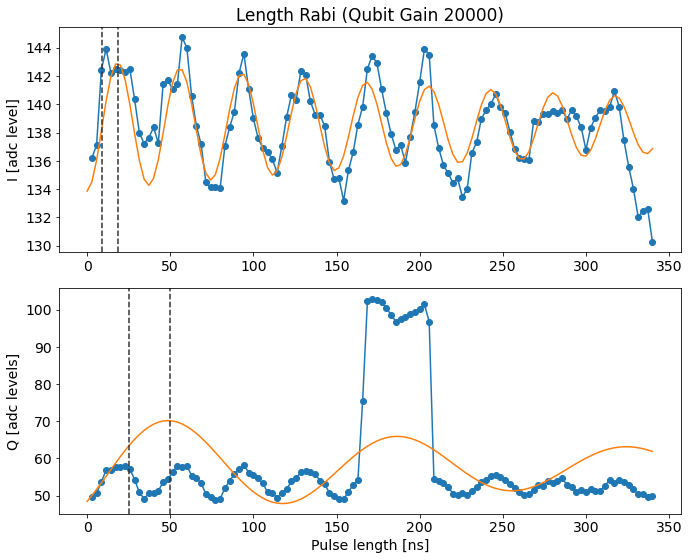

Will use sigma 0.016597798313942345 for amplitude rabi EF


In [110]:
# # TESTING
# # lengthrabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabiEF.data = temp_data

lengthrabiEF.analyze(fit=True)

lengthrabiEF_fit, lengthrabiEF_fit_err = meas.fitting.get_best_fit(lengthrabiEF.data) #, fitfunc=fitter.decaysin)

lengthrabiEF.display(fit=True)
p = lengthrabiEF_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_lenEF = (1/2 - p[2]/180)/2/p[1]
else: pi_lenEF = (3/2 - p[2]/180)/2/p[1]
pi_lenEF = np.max((0.9*pi_lenEF, 0.015)) # since we run the length rabi at a < max gain

lengthrabiEF_decay = p[3]

print(f'Will use sigma {pi_lenEF} for amplitude rabi EF')

In [111]:
if save_data: saved_files.append(lengthrabi.save_data())

## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [112]:
amprabiEF = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

span = 32000
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=30,
    sigma_test=pi_lenEF, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    checkZZ=False,
    checkEF=True, 
    qubits=[qubit_i],
)

print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 96, 9, 58], 'f_ge': [146.3200507751049, 3464.1798421793665, 808.0847336808625, 426.8701802662663], 'f_Q1_ZZ': [3459.6967629797664, 0, 3463.7374335056006, 3463.5464893503636], 'f_ef': [-78.90376315971923, 3364.253, 611.098326885819, 253.02553858942042], 'f_EgGf': [2678.7, 0, 2010.8, 2395.5], 'ZZs': [0.0, -4.7126775455997745, -0.10534620937775685, -0.28344964409794215, -4.236078028296106, 0.0, -0.16869289545775246, -0.2784781391173965, 0.5146242128746508, -0.12676679271078228, 0.0, -0.06125637291711428, 3.0556426555347116, 2.6356995614617063, 3.312733462014023, 0.0], 'pulses': {'pi_ge': {'gain': [24653, 20197, 27992, 24647], 'sigma': [0.0403, 0.02, 0.04, 0.025], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [31065, 13553, 16026, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [27345, 0, 27988, 29136], 'sigma': [0.015, 0, 0.015, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 4 to 136.22225910185486, which is out of bounds -875.4136907473699 to -864.7374497233975. Instead init to -870.0755702353837
Attempted to init fitparam 4 to -870.0755702353837, which is out of bounds 875.7631955413502 to 885.379456745927. Instead init to 880.5713261436385
Pi gain from avgi data [dac units]: 23873
	Pi/2 gain from avgi data [dac units]: 11936
Pi gain from avgq data [dac units]: 21903
	Pi/2 gain from avgq data [dac units]: 10951


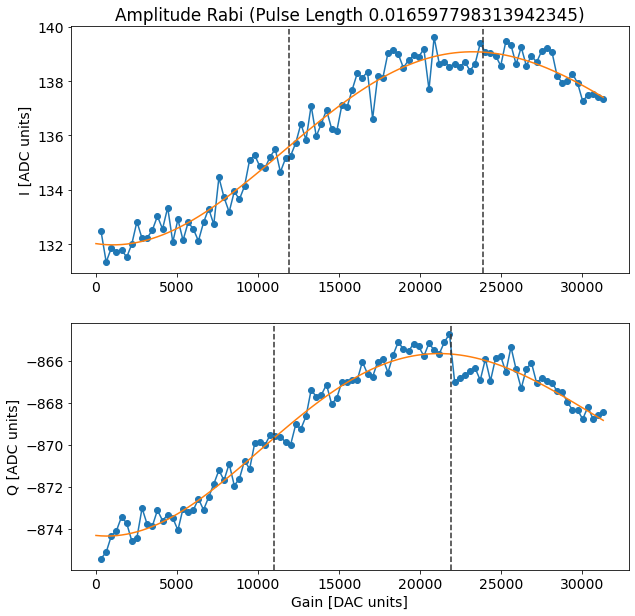

*Set EF pi pulse sigma for qubit 3 to 0.016597798313942345*
*Set EF pi pulse gain for qubit 3 to 21903*
[{'Qubit freq': 4145.6696618844235, 'Pi pulse len': 0.21621550537601955, 'Pi pulse gain': 4133, 'T1': 26.580748110408035, 'T1 err': 5.081093510765457}, {}, {'Res freq': 7693.839333333333, 'Res kappa': 0.18297517457435744, 'Qubit freq': 4808.08917302461, 'Pi pulse len': 0.05851958540275149, 'Pi pulse gain': 18050, 'T1': 9.261929702812196, 'T1 err': 0.5272496289468025}, {'Qubit freq': 4446.964932602277, 'EF pi pulse len': 0.016597798313942345, 'EF pi pulse gain': 21903}]


In [114]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF.data = temp_data

amprabiEF.analyze(fit=True)

amprabiEF_fit, amprabiEF_fit_err = meas.fitting.get_best_fit(amprabiEF.data)

p = amprabiEF_fit

if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabiEF.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabiEF.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i] = amprabiEF.cfg.expt.sigma_test
print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i] = int(pi_gain)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]}*')
results_Qi.update({'EF pi pulse len':yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]})
results_Qi.update({'EF pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]})
print(all_results)

In [115]:
if save_data: saved_files.append(amprabiEF.save_data())

## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [119]:
# yaml_cfg.device.qubit.f_ge[qubit_i] = 145.572034953271
qubitEF_hwhm = 7
# short_T1 = False

In [120]:
ramseyEF_freq = max(min(np.abs(np.ceil(qubitEF_hwhm)), 3), 2)

t2EFr = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq, # [MHz]
    checkZZ=False,
    checkEF=True,
    reps=100,
    rounds=30,
    qubits=[qubit_i],
)

import Pyro4.util
try:
    t2EFr.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 10.966557, which is out of bounds 0.023489697986577185 to 3.5234546979865775. Instead init to 1.7734721979865773
Current pi pulse frequency: 253.02553858942042
Fit frequency from I [MHz]: 1.6698508696001186 +/- 0.00287397594658784
Suggested new pi pulse frequency from fit I [MHz]:
 	254.3556877198203
 	248.3556877198203
T2 Ramsey from fit I [us]: 8.926716721023558
Fit frequency from Q [MHz]: 1.665201816343202 +/- 0.005989416053793644
Suggested new pi pulse frequencies from fit Q [MHz]:
 	254.36033677307722
 	248.36033677307722
T2 Ramsey from fit Q [us]: 5.766645206668142


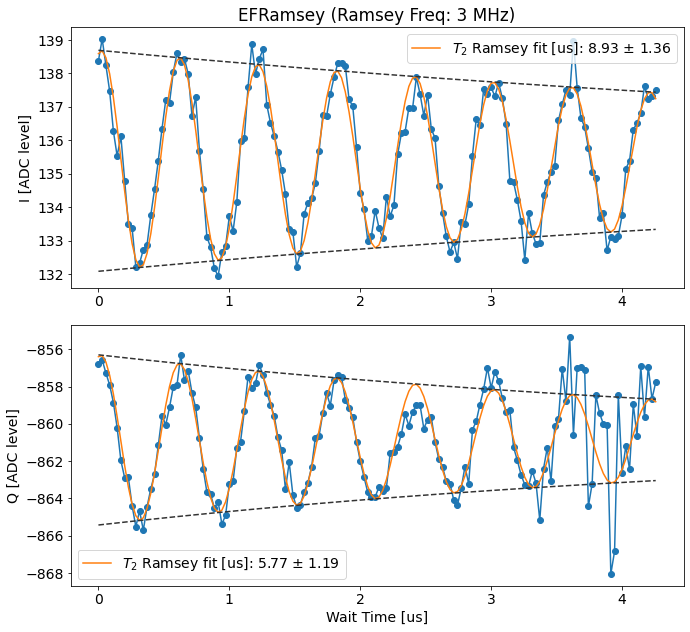

*Set qubit 3 EF freq to 254.36098271568733*
[{'Qubit freq': 4145.6696618844235, 'Pi pulse len': 0.21621550537601955, 'Pi pulse gain': 4133, 'T1': 26.580748110408035, 'T1 err': 5.081093510765457}, {}, {'Res freq': 7693.839333333333, 'Res kappa': 0.18297517457435744, 'Qubit freq': 4808.08917302461, 'Pi pulse len': 0.05851958540275149, 'Pi pulse gain': 18050, 'T1': 9.261929702812196, 'T1 err': 0.5272496289468025}, {'Qubit freq': 4446.964932602277, 'EF pi pulse len': 0.016597798313942345, 'EF pi pulse gain': 21903, 'Qubit EF freq': 4254.360982715687}]


In [121]:
# # TESTING
# # t2EFr = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr.data = temp_data

t2EFr.analyze(fit=True)
t2EFr_fit, t2EFr_fit_err, t2EFr_adjust = meas.fitting.get_best_fit(t2EFr.data, get_best_data_params=['f_adjust_ramsey'])
old_qubit_freq = t2EFr.cfg.device.qubit.f_ef[qubit_i]

if not isinstance(t2EFr_fit, (list, np.ndarray)):
    t2EFr.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr.display(fit=True)
yaml_cfg.device.qubit.f_ef[qubit_i] = old_qubit_freq + t2EFr_adjust[0]
alt_qubit_freq = old_qubit_freq + t2EFr_adjust[1]
print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [241]:
if save_data: saved_files.append(t2EFr.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00000_ramseyEF_qubit3.h5


# Resonator chi shift (e/f)

In [116]:
rspecEF_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspecEF_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 151
rspecEF_chi.cfg.expt = dict(
    start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-abs(results_Qi['Res chi shift (e - g)'])-span, # [MHz]
    # start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=True, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspecEF_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspecEF_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

[-811.3625297153883, 5000, 1000, 0, 17.03715941066355, 326.477619610652]
[-8.03285761e+02 -3.03561876e+05 -1.27177254e+01  5.91794716e+00
 -1.27356982e+02  3.11150862e+02]

Freq with minimum transmission: -813.4817350134015
Freq with maximum transmission: -808.9453111723419
From fit:
	f0: -803.2857613940467
	Qi: -303561.8763070908
	Qe: -12.71772541526503
	Q0: -12.717192628454415
	kappa [MHz]: 63.165337261363334
	phi [radians]: 5.917947164978501


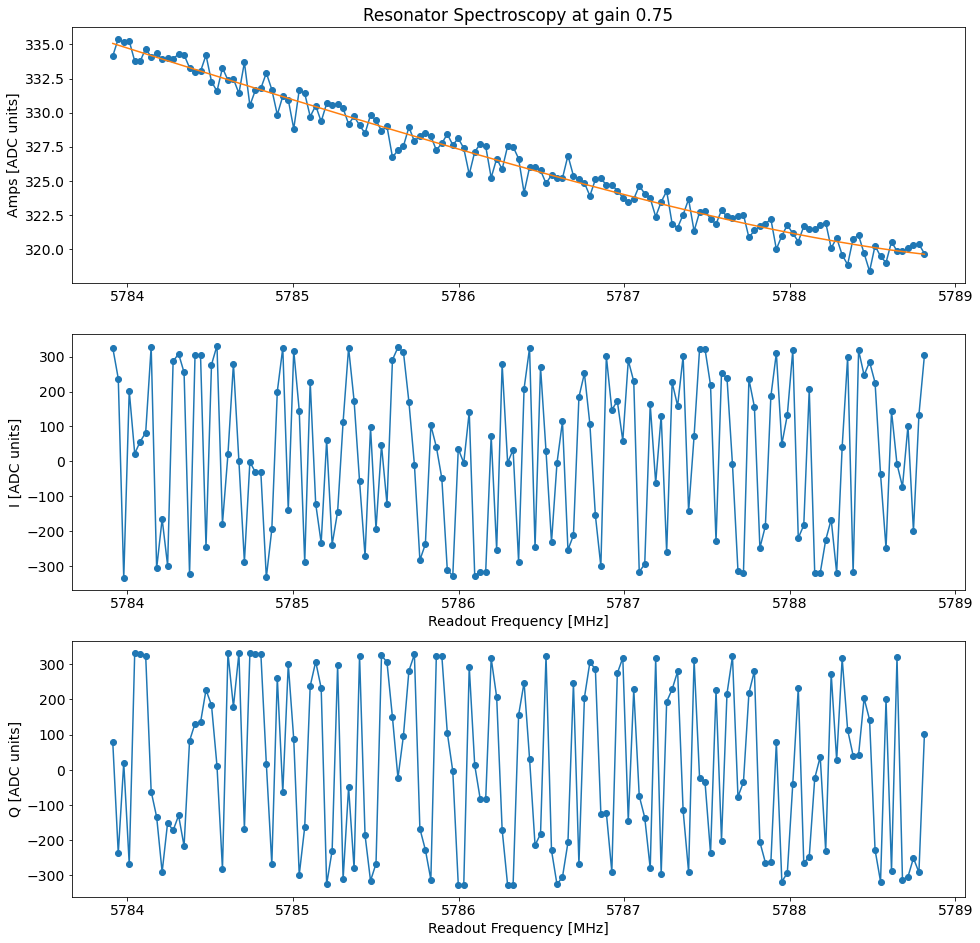

[{'Res freq': 7688.874258045896, 'Res kappa': 0.9756441096550745, 'Qubit freq': 4823.861508259508, 'Pi pulse len': 0.03956011335259716, 'Pi pulse gain': 22779, 'T1': 97.14424019836063, 'T1 err': 4.6355555889821245, 'T2R': 8.312336278065233, 'T2R err': 0.3957274632565941, 'T2E': 17.688832442781287, 'T2E err': 0.7326171278801736, 'Qubit EF freq': 4640.557961214359, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 16093}, {'Res freq': 5783.299615808103, 'Res kappa': 0.30608491399697296, 'Qubit freq': 3472.403818423059, 'Pi pulse len': 0.020738980081829388, 'Pi pulse gain': 23185, 'T1': 52.567929832315315, 'T1 err': 0.6768379550408044, 'T2R': 1.8746149564710788, 'T2R err': 0.1533478261277939, 'T2E': 15.873701812556538, 'T2E err': 0.3698073838910515, 'Res chi shift (e - g)': -0.5463576158940668, 'Qubit EF freq': 603.7170605500958, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 2680, 'Res chi shift (f - g)': 5.546357615894067}, {}, {}]


In [117]:
# # TESTING
# # rspecEF_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspecEF_chi.data = temp_data

rspecEF_chi.analyze(fit=True)
rspecEF_chi_fit = rspecEF_chi.data['fit']
rspecEF_chi.display(fit=True)
# res_freq_f = rspecEF_chi_fit[0]
res_freq_f = rspecEF_chi.data['xpts'][np.argmin(rspecEF_chi.data['amps'])]
results_Qi.update({'Res chi shift (f - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_f - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_f = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [118]:
if save_data: saved_files.append(rspecEF_chi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221007\00000_resonator_spectroscopy_chi_qubit1.h5


# Single Shot

## Single shot optimization

In [23]:
results_Qi['Res kappa'] = 0.18

In [91]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15

span_f = 1.5*abs(results_Qi['Res kappa']) # MHz
npts_f = 12

# span_gain = 0.95
span_gain = 0.5
npts_gain = 1

span_len = 6 # us
npts_len = 2

shotopt.cfg.expt = dict(
    reps=20000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    start_gain=0.90,
    # start_gain=0.15,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain,

    start_len=3,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [30, 96, 9, 58], 'f_ge': [146.3200507751049, 3464.1798421793665, 808.0847336808625, 420.4349909806926], 'f_Q1_ZZ': [3459.6967629797664, 0, 3463.7374335056006, 3463.5464893503636], 'f_ef': [-78.90376315971923, 3364.253, 611.098326885819, 275.76433968698353], 'f_EgGf': [2678.7, 0, 2010.8, 2395.5], 'ZZs': [0.0, -4.7126775455997745, -0.10534620937775685, -0.28344964409794215, -4.236078028296106, 0.0, -0.16869289545775246, -0.2784781391173965, 0.5146242128746508, -0.12676679271078228, 0.0, -0.06125637291711428, 3.0556426555347116, 2.6356995614617063, 3.312733462014023, 0.0], 'pulses': {'pi_ge': {'gain': [24653, 20197, 27992, 28755], 'sigma': [0.0403, 0.02, 0.04, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [31065, 13553, 16026, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [27345, 0, 27988, 29136], 'sigma': [0.015, 0, 0.015, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gai

  0%|          | 0/12 [00:00<?, ?it/s]

freq: 818.7487686190692, gain: 0.9, len: 3.0
	fid ge [%]: 5.345133628340708
freq: 818.7487686190692, gain: 0.9, len: 6.0
	fid ge [%]: 6.115305765288265
freq: 818.771640515891, gain: 0.9, len: 3.0
	fid ge [%]: 8.170204255106379
freq: 818.771640515891, gain: 0.9, len: 6.0
	fid ge [%]: 6.435160879021976
freq: 818.7945124127128, gain: 0.9, len: 3.0
	fid ge [%]: 10.075251881297033
freq: 818.7945124127128, gain: 0.9, len: 6.0
	fid ge [%]: 11.795589779488974
freq: 818.8173843095346, gain: 0.9, len: 3.0
	fid ge [%]: 10.320258006450162
freq: 818.8173843095346, gain: 0.9, len: 6.0
	fid ge [%]: 11.260281507037675
freq: 818.8402562063563, gain: 0.9, len: 3.0
	fid ge [%]: 11.16083706277971
freq: 818.8402562063563, gain: 0.9, len: 6.0
	fid ge [%]: 11.15527888197205
freq: 818.8631281031782, gain: 0.9, len: 3.0
	fid ge [%]: 12.385619280964049
freq: 818.8631281031782, gain: 0.9, len: 6.0
	fid ge [%]: 13.730343258581465
freq: 818.886, gain: 0.9, len: 3.0
	fid ge [%]: 12.940323508087703
freq: 818.886, ga

(5, 0, 1)
[818.74876862 818.77164052 818.79451241 818.81738431 818.84025621
 818.8631281  818.886      818.9088719  818.93174379 818.95461569
 818.97748759 819.00035948]
[0.9]
[3. 6.]
Max fidelity 0.13730343258581465
Set params: 
 angle (deg) -115.52181528805852 
 threshold 67.75093334688476 
 freq [Mhz] 818.8631281031782 
 gain [dac units] 0.9 
 readout length [us] 6.0


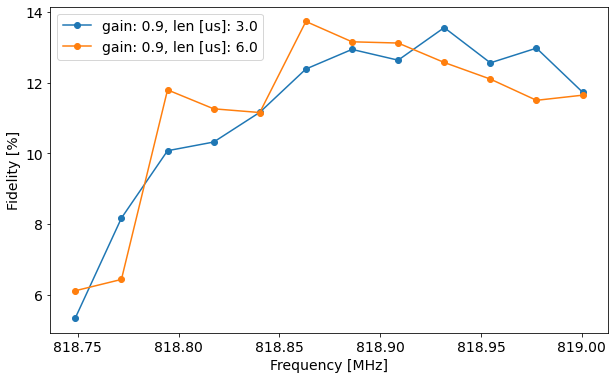

[[[0.05345134 0.06115306]]

 [[0.08170204 0.06435161]]

 [[0.10075252 0.1179559 ]]

 [[0.10320258 0.11260282]]

 [[0.11160837 0.11155279]]

 [[0.12385619 0.13730343]]

 [[0.12940324 0.13155329]]

 [[0.12635632 0.13120328]]

 [[0.13556695 0.12570314]]

 [[0.12560314 0.12100605]]

 [[0.12975973 0.11500575]]

 [[0.11730293 0.11645582]]]


In [92]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [27]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00001_single_shot_opt_qubit0.h5


next qubit

In [148]:
qubit_i = 0
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.183

In [149]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz
span_f = 2*abs(results_Qi['Res kappa']) # MHz
npts_f = 15

span_gain = 0.95
npts_gain = 5

span_len = 10 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=20000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i] - 0.5*span_gain),
    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    # start_gain=0.200,
    start_gain=0.1,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain,

    start_len=10,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [24.0, 96, 29.0, 58], 'f_ge': [805.5035979539057, 3464.4496477749913, 145.572034953271, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [617.0457654660589, 3364.2604416148333, -78.90376315971923, 275.76433968698353], 'f_EgGf': [2009.95, 3364.24341488, 2683.62545251, 2389.97142246], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30306, 22147, 24653, 28755], 'sigma': [0.03538834796958753, 0.01836, 0.04030935960177951, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [13626, 13553, 31065, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [818.885, -812.72, -73.7, 87.5], 'lo_sideband': [1, -1

  0%|          | 0/15 [00:00<?, ?it/s]

freq: 818.702, gain: 0.1, len: 10.0
	fid ge [%]: 1.7400435010875273
freq: 818.702, gain: 0.29000000000000004, len: 10.0
	fid ge [%]: 3.385084627115678
freq: 818.702, gain: 0.48, len: 10.0
	fid ge [%]: 6.150153753843846
freq: 818.702, gain: 0.67, len: 10.0
	fid ge [%]: 6.605330266513326
freq: 818.702, gain: 0.86, len: 10.0
	fid ge [%]: 5.975298764938247
freq: 818.7264, gain: 0.1, len: 10.0
	fid ge [%]: 2.4900622515562887
freq: 818.7264, gain: 0.29000000000000004, len: 10.0
	fid ge [%]: 3.5851792589629485
freq: 818.7264, gain: 0.48, len: 10.0
	fid ge [%]: 5.195129878246956
freq: 818.7264, gain: 0.67, len: 10.0
	fid ge [%]: 5.635281764088204
freq: 818.7264, gain: 0.86, len: 10.0
	fid ge [%]: 6.280157003925098
freq: 818.7508, gain: 0.1, len: 10.0
	fid ge [%]: 1.7200430010750267
freq: 818.7508, gain: 0.29000000000000004, len: 10.0
	fid ge [%]: 2.4751237561878097
freq: 818.7508, gain: 0.48, len: 10.0
	fid ge [%]: 5.615140378509463
freq: 818.7508, gain: 0.67, len: 10.0
	fid ge [%]: 6.51516287

(10, 4, 0)
[818.702  818.7264 818.7508 818.7752 818.7996 818.824  818.8484 818.8728
 818.8972 818.9216 818.946  818.9704 818.9948 819.0192 819.0436]
[0.1  0.29 0.48 0.67 0.86]
[10.]
Max fidelity 0.17391304347826086
Set params: 
 angle (deg) 100.04390635984399 
 threshold 5.337843836489824 
 freq [Mhz] 818.946 
 gain [dac units] 0.86 
 readout length [us] 10.0


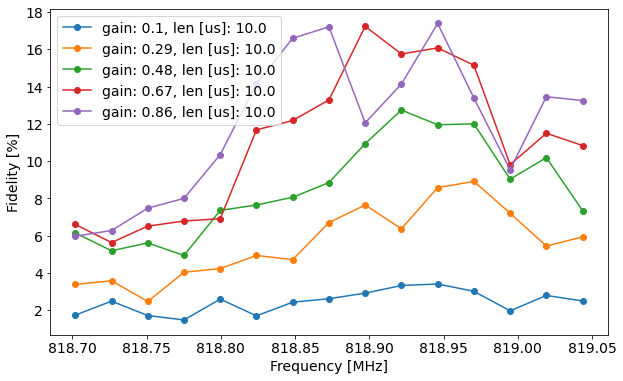

[[[0.01740044]
  [0.03385085]
  [0.06150154]
  [0.0660533 ]
  [0.05975299]]

 [[0.02490062]
  [0.03585179]
  [0.0519513 ]
  [0.05635282]
  [0.06280157]]

 [[0.01720043]
  [0.02475124]
  [0.0561514 ]
  [0.06515163]
  [0.07480187]]

 [[0.01480037]
  [0.04040101]
  [0.04940124]
  [0.0679017 ]
  [0.080052  ]]

 [[0.02600065]
  [0.04240106]
  [0.07360184]
  [0.06915346]
  [0.10355259]]

 [[0.01700085]
  [0.04940371]
  [0.07650383]
  [0.11680292]
  [0.14160708]]

 [[0.02435061]
  [0.04720118]
  [0.08065202]
  [0.12185305]
  [0.16595415]]

 [[0.02620066]
  [0.06705335]
  [0.08855886]
  [0.13286993]
  [0.17210861]]

 [[0.02920073]
  [0.07650383]
  [0.10941641]
  [0.17236724]
  [0.12060302]]

 [[0.03330083]
  [0.06375319]
  [0.12745319]
  [0.15751181]
  [0.14140354]]

 [[0.03410085]
  [0.08580215]
  [0.11955299]
  [0.16080402]
  [0.17391304]]

 [[0.03020076]
  [0.08915223]
  [0.120053  ]
  [0.15150379]
  [0.13391339]]

 [[0.01970148]
  [0.0721018 ]
  [0.09035452]
  [0.09815245]
  [0.09545716]]


In [150]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [151]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00000_single_shot_opt_qubit0.h5


next qubit again

In [152]:
qubit_i = 2
results_Qi = all_results[qubit_i]
results_Qi['Res kappa'] = 0.125

In [158]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz

# span_f = 2*abs(results_Qi['Res kappa']) # MHz
# npts_f = 15
span_f = abs(results_Qi['Res kappa']) # MHz
npts_f = 8

span_gain = 0.95
npts_gain = 5

span_len = 10 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=20000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i] - 0.5*span_gain),
    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    # start_gain=0.200,
    start_gain=0.1,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain,

    start_len=10,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [24, 96, 30, 58], 'f_ge': [805.5035979539057, 3464.4496477749913, 145.572034953271, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [617.0457654660589, 3364.2604416148333, -78.90376315971923, 275.76433968698353], 'f_EgGf': [2009.95, 3364.24341488, 2683.62545251, 2389.97142246], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30306, 22147, 24653, 28755], 'sigma': [0.03539, 0.01836, 0.0403, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [13626, 13553, 31065, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [818.946, -812.617, -73.825, 87.5], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.86, 0.

  0%|          | 0/8 [00:00<?, ?it/s]

freq: -73.8875, gain: 0.1, len: 10.0
	fid ge [%]: 12.63563178158908
freq: -73.8875, gain: 0.29000000000000004, len: 10.0
	fid ge [%]: 39.16597914947874
freq: -73.8875, gain: 0.48, len: 10.0
	fid ge [%]: 49.145887001975844
freq: -73.8875, gain: 0.67, len: 10.0
	fid ge [%]: 34.15256144210816
freq: -73.8875, gain: 0.86, len: 10.0
	fid ge [%]: 38.76275255051011
freq: -73.871875, gain: 0.1, len: 10.0
	fid ge [%]: 13.945348633715843
freq: -73.871875, gain: 0.29000000000000004, len: 10.0
	fid ge [%]: 42.85464229451627
freq: -73.871875, gain: 0.48, len: 10.0
	fid ge [%]: 47.55451090218044
freq: -73.871875, gain: 0.67, len: 10.0
	fid ge [%]: 37.091491010926916
freq: -73.871875, gain: 0.86, len: 10.0
	fid ge [%]: 24.48561214030351
freq: -73.85625, gain: 0.1, len: 10.0
	fid ge [%]: 14.9622443366505
freq: -73.85625, gain: 0.29000000000000004, len: 10.0
	fid ge [%]: 45.63456345634563
freq: -73.85625, gain: 0.48, len: 10.0
	fid ge [%]: 46.54399799724621
freq: -73.85625, gain: 0.67, len: 10.0
	fid ge

(0, 2, 0)
[-73.8875   -73.871875 -73.85625  -73.840625 -73.825    -73.809375
 -73.79375  -73.778125]
[0.1  0.29 0.48 0.67 0.86]
[10.]
Max fidelity 0.4914588700197584
Set params: 
 angle (deg) -137.04077155531243 
 threshold -70.49556895216202 
 freq [Mhz] -73.8875 
 gain [dac units] 0.48 
 readout length [us] 10.0


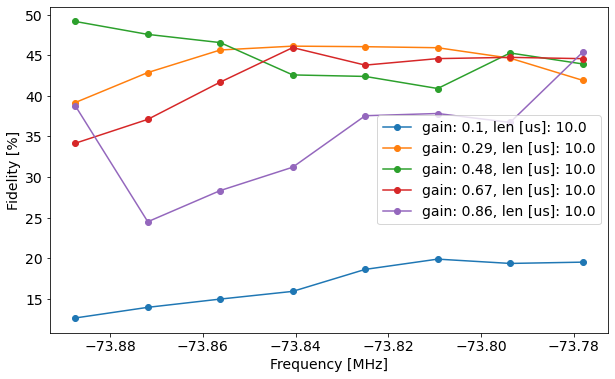

[[[0.12635632]
  [0.39165979]
  [0.49145887]
  [0.34152561]
  [0.38762753]]

 [[0.13945349]
  [0.42854642]
  [0.47554511]
  [0.37091491]
  [0.24485612]]

 [[0.14962244]
  [0.45634563]
  [0.46543998]
  [0.4167835 ]
  [0.28324957]]

 [[0.15910398]
  [0.46107665]
  [0.42563833]
  [0.45928893]
  [0.3120124 ]]

 [[0.18616862]
  [0.46039171]
  [0.42378476]
  [0.43770016]
  [0.37539692]]

 [[0.19881491]
  [0.45912548]
  [0.40889311]
  [0.44571714]
  [0.37813235]]

 [[0.19351451]
  [0.4462566 ]
  [0.45264711]
  [0.4472519 ]
  [0.36711013]]

 [[0.19510488]
  [0.41902333]
  [0.43916958]
  [0.4456674 ]
  [0.45346743]]]


In [159]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [160]:
if save_data: saved_files.append(shotopt.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data\data_221215\00001_single_shot_opt_qubit2.h5


## Best readout parameters

In [58]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)
shot.cfg = AttrDict(deepcopy(yaml_cfg))

shot.cfg.expt = dict(
    reps=30000,
    check_f=False,
    qubit=qubit_i,
)

shot.cfg.device.readout.frequency=freq_opt
shot.cfg.device.readout.gain=gain_opt
shot.cfg.device.readout.readout_length = len_opt # [us]

# shot.cfg.device.readout.frequency=-807.4996158081035
# shot.cfg.device.readout.gain=0.600
# shot.cfg.device.readout.readout_length = 7 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [24, 96, 30, 58], 'f_ge': [810.826541944993, 3464.727488396267, 145.572034953271, 425.57], 'f_Q1_ZZ': [3463.826339688734, 0, 3459.6698976969255, 3463.5104694090664], 'f_ef': [611.098326885819, 3364.253, -78.90376315971923, 275.76433968698353], 'f_EgGf': [2010.8, 0, 2678.7, 2395.5], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [16026, 22147, 24653, 28755], 'sigma': [0.066, 0.01836, 0.0403, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [16026, 13553, 31065, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [27777, 0, 16840, 30000], 'sigma': [0.015, 0, 0.024187907740573854, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [4250, 0, 2679, 2850], 'sigma': [0.171, 0, 0.227, 0.293], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [818.886, -812.617, -73.825, 87.436], 'lo_sideband': [1, -1, 1, 1], 'gain': [0.91, 0.86, 0.48, 0.75], 'readout_length': [10, 

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

Unrotated:
Ig -38.74487471526196 +/- 22.94153795843381 	 Qg -43.47396680767979 +/- 22.95342676473534 	 Amp g 58.23359087929053
Ie -35.68825252196551 +/- 22.7266116016861 	 Qe -53.319069313374555 +/- 24.115502172052253 	 Amp e 64.16053709653636
Rotated:
Ig 29.991041621046932 +/- 22.94153795843381 	 Qg -49.992734886447444 +/- 22.95342676473534 	 Amp g 58.29868025043096
Ie 40.40321008293962 +/- 22.7266116016861 	 Qe -49.74544219162133 +/- 24.115502172052253 	 Amp e 64.08610148734351


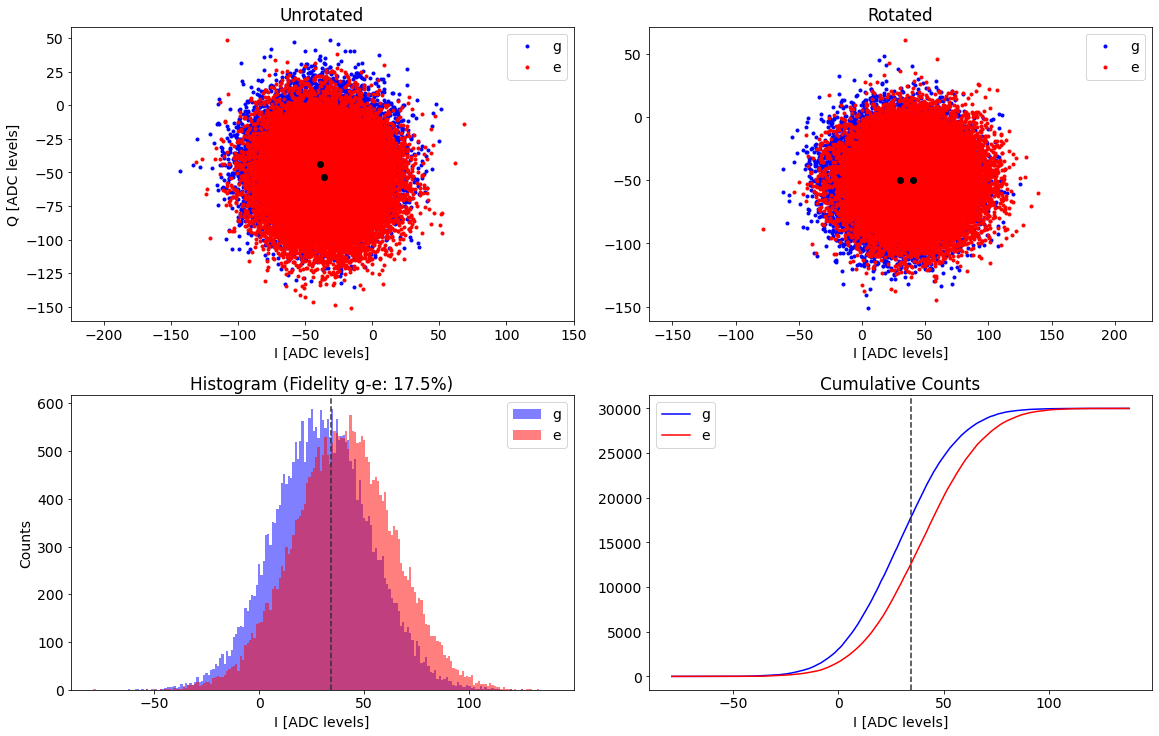

ge fidelity (%): 17.476957949299155
rotation angle (deg): 72.75192888293701
threshold ge: 34.35008246690428


In [59]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True)

In [151]:
if save_data: saved_files.append(shot.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221007\00000_single_shot_qubit1.h5


# Results

In [31]:
print(yaml_cfg)
for Qi, results in enumerate(all_results):
    print(f'Qubit {Qi}')
    for key, value in results.items():
        print(f'\t{key}: {value}')
    print()

for saved_file in saved_files:
    print(saved_file)

{'device': {'qubit': {'T1': [30, 96, 24, 58], 'f_ge': [145.4938020756419, 3464.7365993949606, 807.648350423252, 422.21483099382095], 'f_Q1_ZZ': [3459.6967629797664, 0, 3463.7374335056006, 3463.5464893503636], 'f_ef': [-78.90376315971923, 3364.253, 611.098326885819, 275.76433968698353], 'f_EgGf': [2678.7, 0, 2010.8, 2395.5], 'ZZs': [0.0, -4.7126775455997745, -0.10534620937775685, -0.28344964409794215, -4.236078028296106, 0.0, -0.16869289545775246, -0.2784781391173965, 0.5146242128746508, -0.12676679271078228, 0.0, -0.06125637291711428, 3.0556426555347116, 2.6356995614617063, 3.312733462014023, 0.0], 'pulses': {'pi_ge': {'gain': [24653, 3369, 16026, 28755], 'sigma': [0.0403, 0.11485552942205476, 0.066, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [31065, 13553, 16026, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [27345, 0, 27988, 29136], 'sigma': [0.015, 0, 0.015, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 